In [1]:
import pandas as pd
import plotly.graph_objects as go
from scipy.interpolate import CubicSpline

In [17]:
updated_df = pd.read_csv("https://raw.githubusercontent.com/cdcepi/FluSight-forecast-hub/refs/heads/main/target-data/target-hospital-admissions.csv")
updated_df = updated_df[updated_df["location_name"] == "US"]
updated_df = updated_df[["date", "value"]]
updated_df["date"] = pd.to_datetime(updated_df["date"])
updated_df.set_index("date", inplace = True)
updated_df.sort_values(by = "date", inplace = True)
updated_df["ds"] = updated_df.index

In [18]:
X = updated_df["ds"]
y = updated_df["value"]

In [20]:
cs = CubicSpline(x = X, y = y)

In [5]:
X_daily = X.asfreq("D")

In [21]:
y_smooth = cs(X.index)

In [23]:
spline_df = pd.DataFrame(data = y_smooth, index = X.index, columns = ["value"])
spline_df

,value
date,
2022-02-05,1091.0
2022-02-12,1158.0
2022-02-19,1490.0
2022-02-26,1603.0
2022-03-05,1791.0
...,...
2025-06-07,1487.0
2025-06-14,1437.0
2025-06-21,1279.0


In [25]:
from sklearn.metrics import mean_absolute_error

In [26]:
mean_absolute_error(spline_df["value"], updated_df["value"])

0.0

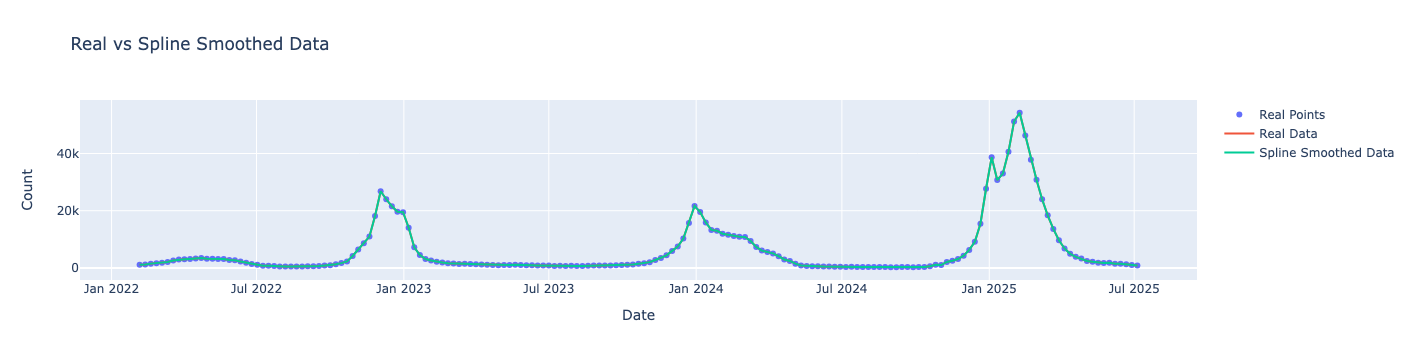

In [24]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = X, y = y, mode = "markers", name = "Real Points"))
fig.add_trace(go.Scatter(x = X, y = y, mode = "lines", name = "Real Data"))
fig.add_trace(go.Scatter(x = spline_df.index, y = spline_df["value"], mode = "lines", name = "Spline Smoothed Data"))
fig.update_layout(title = "Real vs Spline Smoothed Data", xaxis_title = "Date", yaxis_title = "Count", hovermode = "x")
fig.show()

In [10]:
ma_series = updated_df["value"].rolling(window = 3).mean()

In [12]:
ma_df = ma_series.to_frame()
ma_df

,value
date,
2022-02-05,NaN
2022-02-12,NaN
2022-02-19,1246.333333
2022-02-26,1417.000000
2022-03-05,1628.000000
...,...
2025-06-07,1660.333333
2025-06-14,1576.666667
2025-06-21,1401.000000


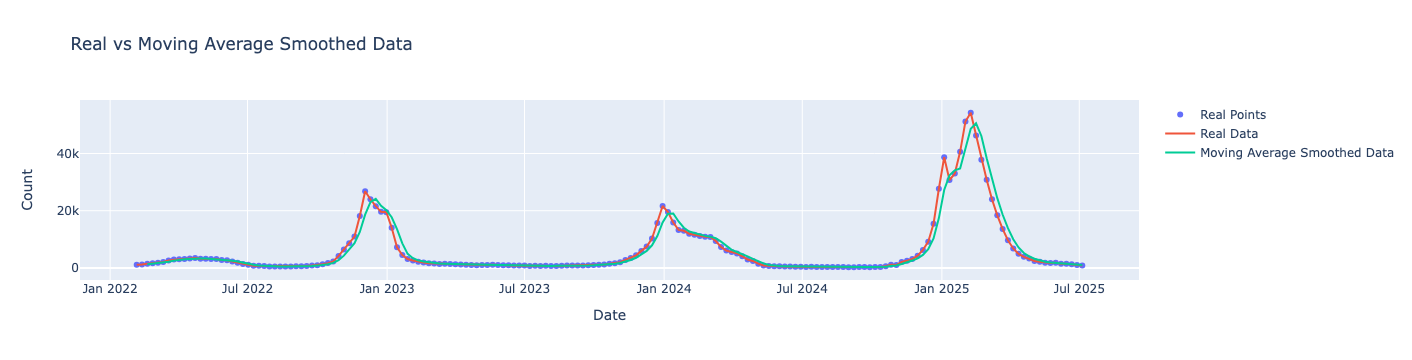

In [14]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = X, y = y, mode = "markers", name = "Real Points"))
fig.add_trace(go.Scatter(x = X, y = y, mode = "lines", name = "Real Data"))
fig.add_trace(go.Scatter(x = ma_df.index, y = ma_df["value"], mode = "lines", name = "Moving Average Smoothed Data"))
fig.update_layout(title = "Real vs Moving Average Smoothed Data", xaxis_title = "Date", yaxis_title = "Count", hovermode = "x")
fig.show()

In [10]:
import sys

In [11]:
sys.path.insert(1, "/sfs/gpfs/tardis/home/hmf6av/TimeSeriesComparisons/Processors")

In [12]:
from TimeLLMProcessors import FixedModelTimeLLMProcessor, UpdatingModelTimeLLMProcessor

In [13]:
Processor = FixedModelTimeLLMProcessor(overall_df=updated_df, dates=["2024-10-05", "2024-10-19", "2024-11-02", "2024-11-16", "2024-12-07"])

In [14]:
Processor.create_training_dfs(value_col="value")

In [15]:
prompt = "This dataset contains data on weekly flu hospitalizations in the United States. There is a yearly (52 weeks) seasonality. There is a peak in January, and there is a rapid increase in December in number of hospitalizations."

In [16]:
config = {
    "input_size": 8,
    "windows_batch_size": {"type": "categorical",
                           "values": [32, 64, 128]},
    "inference_windows_batch_size": {"type": "integer",
                                     "values": [32, 128]}

}

In [17]:
Processor.create_fixed_model(h = 4, freq = "W-SAT", prompt = prompt, model_name = "non-spline", config = config)

[I 2025-07-16 16:16:42,231] A new study created in memory with name: no-name-6358bf0e-34f7-4882-80fc-0b331b925cb5
[rank: 0] Seed set to 1
2025-07-16 16:16:44.376811: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-16 16:16:44.434961: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-16 16:16:44.663447: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-16 16:16:44.663483: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-1

Successfully loaded model: gpt2-medium


/home/hmf6av/.local/lib/python3.11/site-packages/neuralforecast/common/_base_model.py:537: UserWarning:

val_check_steps is greater than max_steps, setting val_check_steps to max_steps.

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type               | Params | Mode 
-------------------------------------------------------------------
0 | loss                | MAE                | 0      | train
1 | padder_train        | ConstantPad1d      | 0      | train
2 | scaler              | TemporalNorm       | 0      | train
3 | llm                 | GPT2Model          | 354 M  | eval 
4 | patch_embedding     | PatchEmbedding     | 1.5 K  | train
5 | mapping_layer       | Linear             | 51.5 M | train
6 | reprogramming_layer | ReprogrammingLayer | 3.2 M  | train
7 | output_projection   | FlattenHead        | 516    | train
8 | normalize_layers    | Re

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

[W 2025-07-16 16:16:58,000] Trial 0 failed with parameters: {'windows_batch_size': 128, 'inference_windows_batch_size': 61} because of the following error: OutOfMemoryError('CUDA out of memory. Tried to allocate 74.00 MiB. GPU 0 has a total capacity of 31.73 GiB of which 25.81 MiB is free. Including non-PyTorch memory, this process has 31.60 GiB memory in use. Of the allocated memory 31.22 GiB is allocated by PyTorch, and 2.70 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)').
Traceback (most recent call last):
  File "/home/hmf6av/.local/lib/python3.11/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/sfs/gpfs/tardis/home/hmf6av/TimeSeriesComparisons/Processo

OutOfMemoryError: CUDA out of memory. Tried to allocate 74.00 MiB. GPU 0 has a total capacity of 31.73 GiB of which 25.81 MiB is free. Including non-PyTorch memory, this process has 31.60 GiB memory in use. Of the allocated memory 31.22 GiB is allocated by PyTorch, and 2.70 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)